# 2 Components Data

In [1]:
import numpy as np
import time

from ml4pd import components
import dist_utils
from ml4pd.aspen_units import Distillation
from ml4pd.streams import MaterialStream

input_molecules = dist_utils.get_mol_labels()
components.set_components(input_molecules['name'].to_list())

raw_data = dist_utils.get_benchmark_data(comp=2, date='220505')
data = dist_utils.add_name_columns(raw_data, input_molecules[['name', 'mol']])
data = dist_utils.add_flow_perc(data)
data = dist_utils.rename_flowrate_columns(data)

## Benchmark Data Info

In [2]:
input_molecules.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
name,acetone,2-butanone,3-pentanone,3-hexanone,4-heptanone,4-octanone,5-nonanone,5-decanone,6-undecanone,6-dodecanone,6-tridecanone,7-tetradecanone,8-pentadecanone,water
mol,C3-ONE,C4-ONE,C5-ONE,C6-ONE,C7-ONE,C8-ONE,C9-ONE,C10-ONE,C11-ONE,C12-ONE,C13-ONE,C14-ONE,C15-ONE,H2O
smiles,CC(=O)C,CCC(=O)C,CCC(=O)CC,CCCC(=O)CC,CCCC(=O)CCC,CCCCC(=O)CCC,CCCCC(=O)CCCC,CCCCCC(=O)CCCC,CCCCCC(=O)CCCCC,CCCCCCC(=O)CCCCC,CCCCCCCC(=O)CCCCC,CCCCCCCC(=O)CCCCCC,CCCCCCCC(=O)CCCCCCC,O


In [3]:
raw_data.describe().T

,count,mean,std,min,25%,50%,75%,max
temp_dist,12096.0,173.929239,105.194330,1.485171e+00,9.154284e+01,154.096750,250.946966,407.946556
temp_bott,12096.0,183.039972,104.974993,1.027061e+01,9.793269e+01,160.147656,259.470192,409.128699
temp_feed,12096.0,178.873940,105.192634,9.776815e+00,9.730620e+01,158.983986,256.880189,407.988078
duty_condensor,12096.0,-123319.488293,113010.590464,-4.928788e+05,-2.034318e+05,-72794.282000,-30670.924750,-4.151111
duty_reboiler,12096.0,123500.097689,113015.009374,-1.773669e-01,3.077638e+04,72978.959950,203765.868000,492886.176000
flowrate_bott_A,12096.0,0.065339,0.098728,0.000000e+00,3.100000e-07,0.014060,0.094588,0.438902
flowrate_bott_B,12096.0,0.482434,0.219551,2.692827e-10,3.285993e-01,0.514865,0.637710,0.975220
flowrate_feed_A,12096.0,0.242193,0.141914,5.000000e-02,7.692308e-02,0.261905,0.344828,0.454545
flowrate_feed_B,12096.0,0.757807,0.141914,5.454545e-01,6.551724e-01,0.738095,0.923077,0.950000
flowrate_dist_A,12096.0,0.176902,0.131861,2.253969e-04,5.282506e-02,0.161820,0.278296,0.538822


## Time Benchmark

In [4]:
times = []
for i in range(0, 10):
    start_time = time.time()
    feed_stream = MaterialStream(stream_type="feed")(
        vapor_fraction=data['vapor_fraction'].to_list(),
        pressure=data['feed_pressure'].to_list(),
        molecules=dist_utils.get_name_columns(data).to_dict('list'),
        flowrates=dist_utils.get_flowrate_columns(data).to_dict('list'),
    )
    
    dist_col = Distillation(
        no_stages = data['no_stages'].to_list(),
        feed_stage =  data['feed_stage'].to_list(),
        pressure = data['pressure_atm'].to_list(),
        reflux_ratio = data['ratio_reflux'].to_list(),
        boilup_ratio = data['ratio_boilup'].to_list(),
        verbose=False
    )

    bott_stream, dist_stream = dist_col(feed_stream)
    
    times.append(time.time() - start_time)

ordered_data = dist_utils.sort_targets_by_weight(data, feed_stream._mw_idx)

average = np.mean(times).round(2)
std = np.std(times).round(2)

print(f"{len(data)} data pts take {average} +/- {std} seconds to predict.")

12096 data pts take 4.32 +/- 0.52 seconds to predict.


## Classifier Benchmark

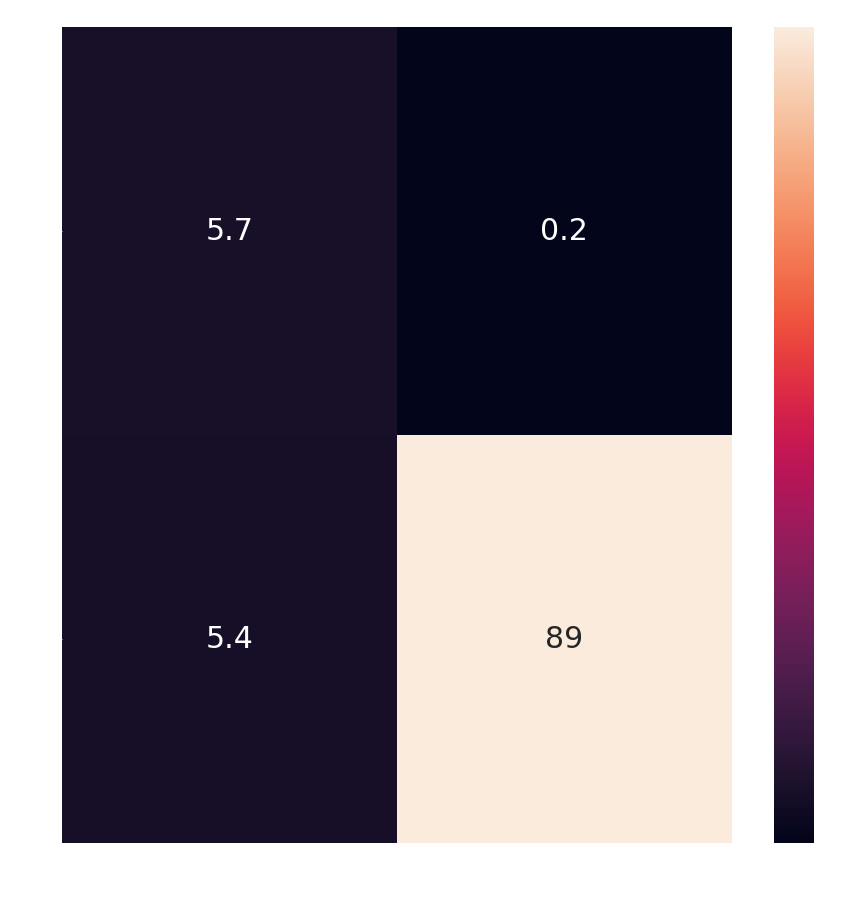

In [5]:
ok_idx = np.array(ordered_data[ordered_data['Status'] == 'OK'].index)
dist_utils.plot_confusion_matrix(ordered_data, dist_col.status)

## Flowrates Benchmark

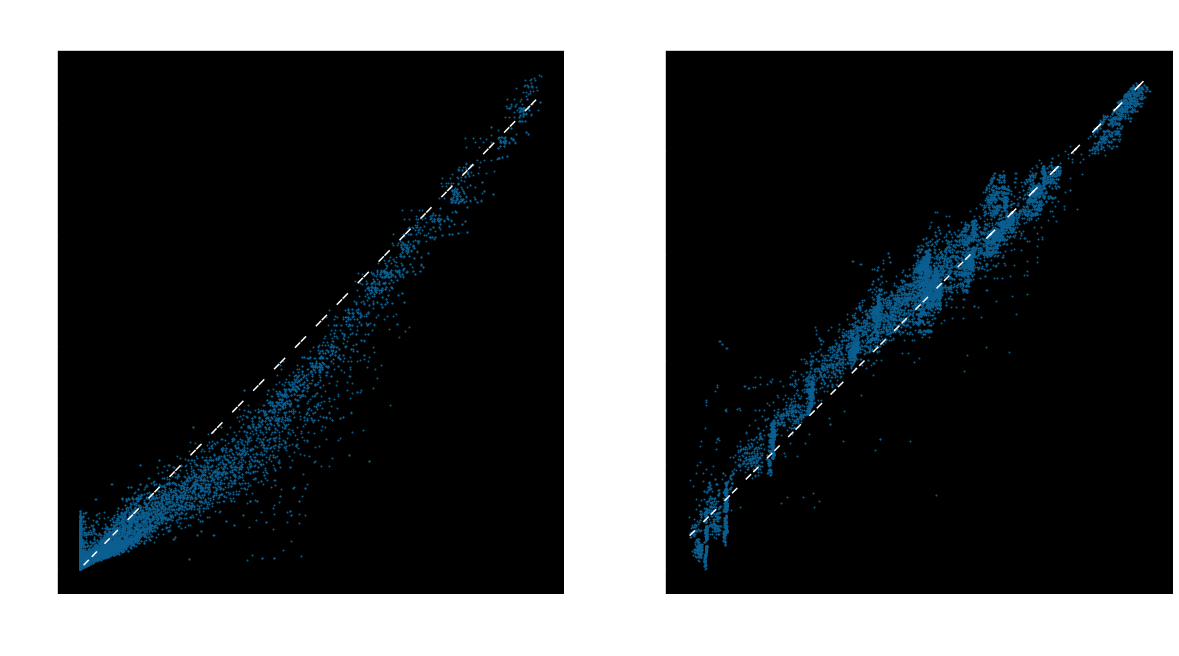

In [6]:
dist_utils.plot_flow(
    y_true=ordered_data.loc[ok_idx],
    y_pred=bott_stream.flow.loc[ok_idx]
)

## Duty Benchmark

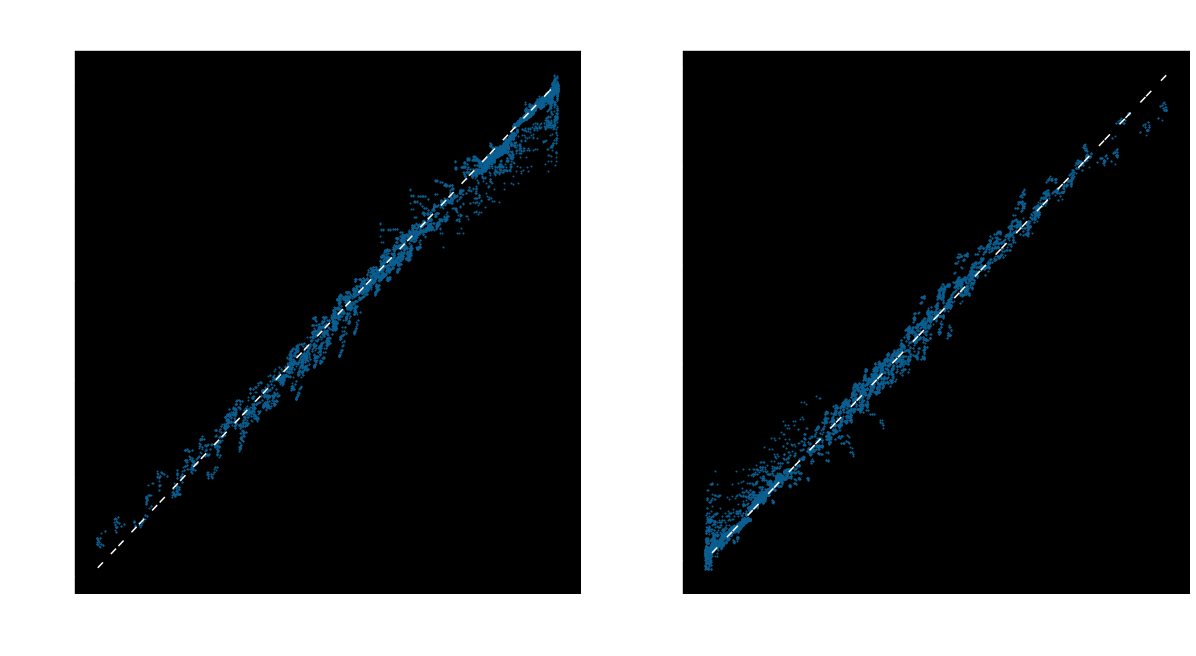

In [7]:
dist_utils.plot_duty(ordered_data, dist_col, ok_idx)

## Temperature Benchmark

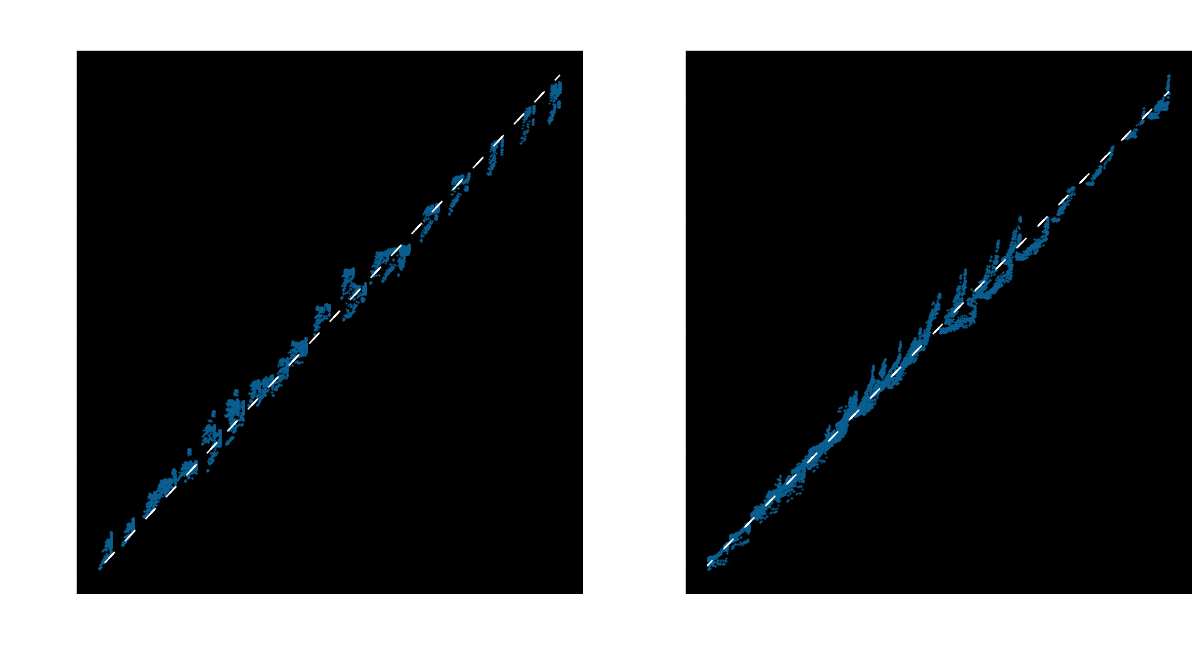

In [8]:
dist_utils.plot_temp(ordered_data, bott_stream, dist_stream, ok_idx)

## Mean Absolute Errors

In [9]:
dist_utils.evaluate_flow(
    ordered_data.loc[ok_idx], 
    bott_stream.flow.loc[ok_idx], 
    metric='mae'
)

,flowrate_bott_A,flowrate_bott_B,mean
0,0.01558,0.036244,0.025912


In [10]:
dist_utils.evaluate_duty(
    ordered_data, 
    dist_col, 
    ok_idx, 
    metric='mae'
)

,condensor_duty,reboiler_duty,mean
0,7781.799472,7681.774765,7731.787119


In [11]:
dist_utils.evaluate_temp(
    ordered_data, 
    bott_stream, 
    dist_stream, 
    ok_idx, 
    metric='mae'
)

,bott_temp,dist_temp,mean
0,8.506879,5.823343,7.165111
